<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW02_Trzeciak_Piotr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework nr 2 (Unsupervised learning - Clustering)
At first I copied a code to generate 'Micky Mouse' dataset.

Later Homework - how to set boundaries between classes and then how I justify K=3 as the best pick (and present the algorithm that does it for me).

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import ListedColormap

In [51]:
# ----------------------------------------------------------------------
# SECTION 1: Define the data
# ----------------------------------------------------------------------
np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
data_X = np.vstack([data1, data2, data3])
N, d = data_X.shape  # should be (500, 2)


In [52]:
# ----------------------------------------------------------------------
# SECTION 2: Define functions for E-step & M-step
# ----------------------------------------------------------------------
def gaussian_pdf(x, mean, cov):
    """
    Compute multivariate Gaussian pdf value at x, given mean and cov.
    x is (d, ) vector, mean is (d, ), cov is (d, d).
    """
    d_ = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2*np.pi)**d_ * det_cov)
    diff = x - mean
    exponent = -0.5 * (diff @ inv_cov @ diff.T)
    return norm_const * np.exp(exponent)

def e_step(data, pi, mu, Sigma):
    """
    E-step: compute the responsibilities resp[n, k] = p(z_n=k | x_n, theta).
    """
    N, _ = data.shape
    K = len(pi)
    resp = np.zeros((N, K))

    for n in range(N):
        for k in range(K):
            resp[n, k] = pi[k] * gaussian_pdf(data[n], mu[k], Sigma[k])
        resp[n, :] /= np.sum(resp[n, :])  # normalize

    return resp

def m_step(data, resp):
    """
    M-step: given responsibilities, update pi, mu, Sigma.
    """
    N, d_ = data.shape
    K = resp.shape[1]

    Nk = np.sum(resp, axis=0)  # shape (K,)

    # Update pi
    pi_new = Nk / N

    # Update mu
    mu_new = np.zeros((K, d_))
    for k in range(K):
        mu_new[k] = np.sum(resp[:, k].reshape(-1,1)*data, axis=0) / Nk[k]

    # Update Sigma
    Sigma_new = []
    for k in range(K):
        S_k = np.zeros((d_, d_))
        for n in range(N):
            diff = data[n] - mu_new[k]
            S_k += resp[n, k] * np.outer(diff, diff)
        S_k /= Nk[k]
        Sigma_new.append(S_k)
    Sigma_new = np.array(Sigma_new)

    return pi_new, mu_new, Sigma_new

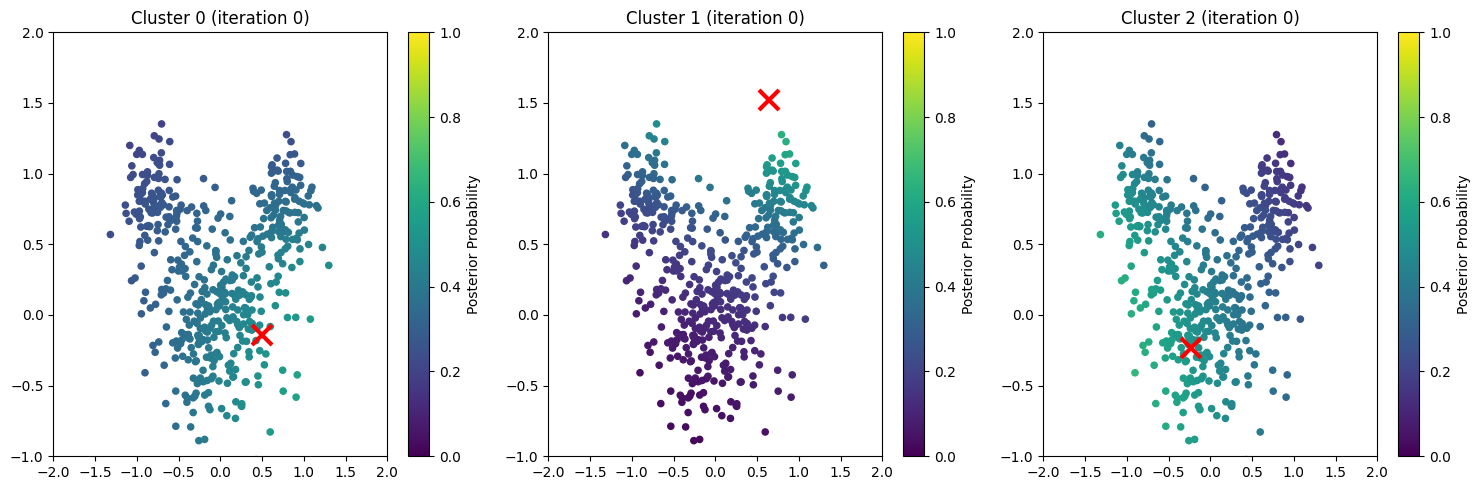

In [53]:
# ----------------------------------------------------------------------
# SECTION 3: Initialize first posterior & plot the initial state for K = 3
# ----------------------------------------------------------------------
# We'll store the EM parameters in global variables so we can update them
# within our EM algorithm.
K = 3
np.random.seed(42)
pi = np.ones(K) / K
mu = np.random.randn(K, d)
Sigma = np.array([np.eye(d) for _ in range(K)])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# We'll create one scatter per cluster:
scatters = []
center_plots = []

# Initialize the responsibilities (before first iteration) just for plotting the colors
resp_init = e_step(data_X, pi, mu, Sigma)


for k in range(K):
    # Scatter for the data with color = responsibilities for cluster k
    sc = axes[k].scatter(data_X[:, 0], data_X[:, 1],
                         c=resp_init[:, k], cmap='viridis',
                         s=20, vmin=0, vmax=1)

    scatters.append(sc)

    # Plot for the cluster center: "X" in red
    cp, = axes[k].plot(mu[k,0], mu[k,1], 'rx', markersize=14, mew=3)
    center_plots.append(cp)

    axes[k].set_title(f'Cluster {k} (iteration 0)')
    axes[k].set_xlim([-2, 2])
    axes[k].set_ylim([-1, 2])

    # Add a colorbar for each subplot
    cbar = fig.colorbar(sc, ax=axes[k])
    cbar.set_label('Posterior Probability')

plt.tight_layout()
plt.show()

# Now we write a function for EM_algorithm to calculate posteriors.


In [54]:
def EM_algorithm(data_X, K, iterations):
  np.random.seed(1231)
  pi = np.ones(K) / K
  mu = np.random.randn(K, d)
  Sigma = np.array([np.eye(d) for _ in range(K)])
  for _ in range(iterations):
    resp = e_step(data_X, pi, mu, Sigma)
    pi, mu, Sigma = m_step(data_X, resp)
  return pi, mu, Sigma
pi, mu, Sigma = EM_algorithm(data_X, K, 100)

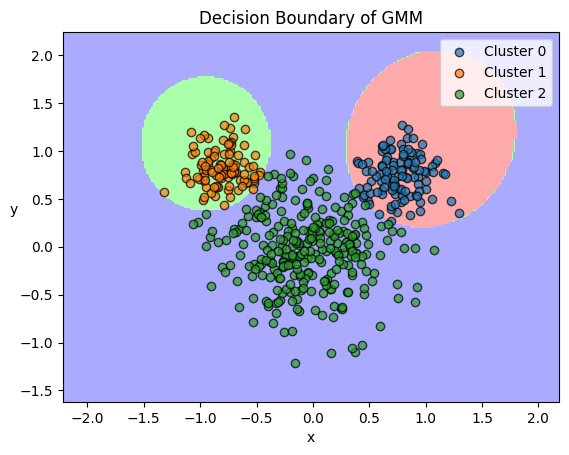

In [55]:
def plot_decision_boundary(data_X, pi, mu, Sigma):
    """Plots the decision boundary for the GMM clusters."""

    # Create a meshgrid for the decision boundary plot
    x_min, x_max = data_X[:, 0].min() - 0.9, data_X[:, 0].max() + 0.9
    y_min, y_max = data_X[:, 1].min() - 0.4, data_X[:, 1].max() + 0.9
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict the cluster for each point in the meshgrid
    Z = np.zeros_like(xx)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            point = np.array([xx[i, j], yy[i, j]])
            probabilities = np.array([pi[k] * gaussian_pdf(point, mu[k], Sigma[k]) for k in range(K)])
            Z[i, j] = np.argmax(probabilities)  # Assign the cluster with the highest probability

    # Create a custom colormap for the clusters
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot the data points, colored by their assigned cluster from the EM algorithm
    # Calculate cluster assignments for the original data
    resp = e_step(data_X, pi, mu, Sigma)  # Get responsibilities
    cluster_assignments = np.argmax(resp, axis=1)  # Assign to cluster with max responsibility

    for k in range(K):
        cluster_points = data_X[cluster_assignments == k]  # Select points for cluster k
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    label=f'Cluster {k}', alpha=0.7, edgecolors='k')

    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.title('Decision Boundary of GMM')
    plt.legend()
    plt.show()

# Call the function to plot the decision boundary
plot_decision_boundary(data_X, pi, mu, Sigma)


The region behind green and red is blue - that belongs to 3rd class. This is counterintuitive, but reasonable, becouse variances in first two groups are significantly smaller than third's. So probability of points further from center of 1&2 decrease faster than from 3. That's why points as y is large and/or |x| is large - are attributed to class 3.

# Secondary question - (How to chose K)

In [56]:
def predict_gmm(X, pi, mu, Sigma):
    """
    Predict cluster assignments for each point in X
    """
    responsibilities = e_step(X, pi, mu, Sigma)
    return np.argmax(responsibilities, axis=1)


In [60]:
import pandas as pd
from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(data_X, K_values, max_iter=100):
    results = []

    for K in K_values:
        # Skip K=1 as silhouette score isn't defined for a single cluster
        if K == 1:
            results.append({'K': K, 'Silhouette Score': np.nan})
            continue

        # Run EM algorithm
        pi, mu, Sigma = EM_algorithm(data_X, K, max_iter)

        # Get cluster assignments
        cluster_labels = predict_gmm(data_X, pi, mu, Sigma)

        # Calculate silhouette score
        if len(np.unique(cluster_labels)) > 1:  # Ensure we have at least 2 clusters with data
            score = silhouette_score(data_X, cluster_labels)
        else:
            score = np.nan

        results.append({'K': K, 'Silhouette Score': score})

    # Create DataFrame
    df_results = pd.DataFrame(results)

    return df_results

# Calculate silhouette scores for K values 1 through 6
K_values = [1, 2, 3, 4, 5, 6]
silhouette_df = calculate_silhouette_scores(data_X, K_values)

# Print the results
print("Silhouette Scores for different K values:")
print(silhouette_df)


Silhouette Scores for different K values:
   K  Silhouette Score
0  1               NaN
1  2          0.404966
2  3          0.463136
3  4          0.331856
4  5          0.341943
5  6          0.338223


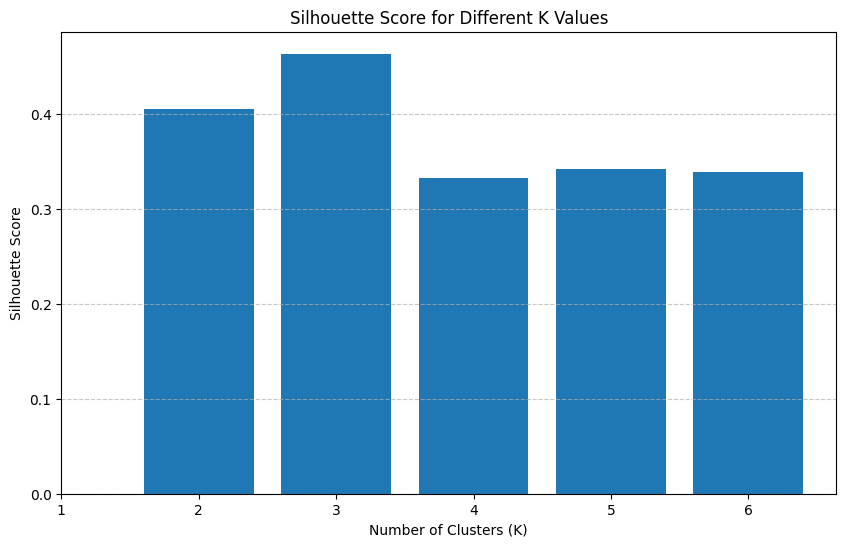

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(silhouette_df['K'], silhouette_df['Silhouette Score'])
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values')
plt.xticks(K_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# As we can see - the highest Silhouette Score is for K = 3, and it's one of good methods for finding the optimal K.